In [12]:
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import os
import matplotlib as mpl
seaborn.set_context('talk')

In [13]:
with open('active_learning_data/dataset_names.txt') as f:
    names = f.readlines()
    names = [n[:-1] for n in names]
print(names)
print(len(names))

['antibacterial', 'anticancer', 'antifungal', 'antiHIV', 'antiMRSA', 'antiparasital', 'antiviral', 'hemolytic', 'soluble', 'shp2', 'tula2', 'human']
12


(0.5075757041757355, 0.03161597608256154)

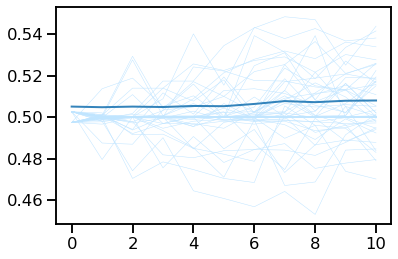

In [14]:
def plot_condition(ax, label, color, linestyle, location, trace=True, horizontal=False):
    # load lines
    avg = None
    aucs = []
    # mimic how an alpha would blend,
    # but don't use alpha so that we don't create
    # false "mean lines"
    base_color = mpl.colors.to_rgb(color)
    base_hsv = mpl.colors.rgb_to_hsv(base_color)
    base_hsv[1] *= 0.3
    base_hsv[2] = 1.0
    trace_color = mpl.colors.hsv_to_rgb(base_hsv)
    for i in range(100):
        fn = '{}/{}_withheld_accuracy.txt'.format(location, str(i).zfill(4))
        auc = '{}/{}_auc.txt'.format(location, str(i).zfill(4))
        if not os.path.exists(fn):
            break
        d = np.genfromtxt(fn)
        auc = np.genfromtxt(auc)
        aucs.append(auc)
        if avg is None:
            avg = d
        else:
            avg += d
        if trace:
            ax.plot(d, alpha=1.0, lw=0.5, color=trace_color, linestyle=linestyle)        
    # should always go one past to get a break
    if i == 0:
        raise RuntimeError('Failed in ' + fn)
    avg /= i
    if horizontal:
        ax.axhline(avg[-1], lw=1.0 if trace else 1.5, label=label, color=color, linestyle=linestyle)
    else:
        ax.plot(avg, alpha=0.9, lw=2.0 if trace else 1.5, label=label, color=color, linestyle=linestyle)
    return (np.mean(aucs), np.std(aucs))
plt.figure()
ax = plt.gca()
#plot_condition(ax, 'foo', 'C0', '-', 'reptile-weights/random/0/', trace=False)
plot_condition(ax, 'foo', 'C0', '-', 'reptile-models/umin/8/', trace=True)

[(0.809212278106509, 0.0),
 (0.7444935096153846, 0.12701209322709023),
 (0.6069192344674557, 0.20598945177833353),
 (0.7616370562130177, 0.1320932103159695),
 (0.6199243343195266, 0.20630768236692285)]

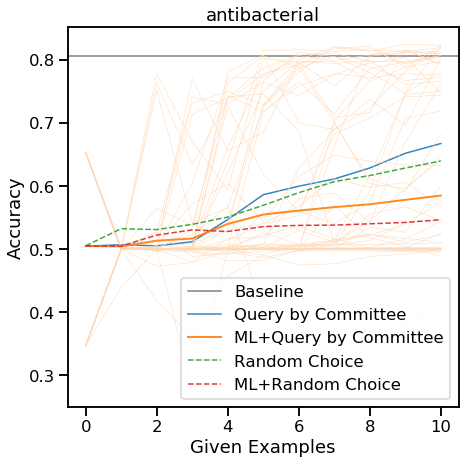

In [16]:
def plot_dataset(ax, ml_location, location, strategy, index, legend=False, ml=True, zoom=False):
    ax.set_title(names[index])
    index = str(index)
    strategy_names = {'umin': 'Uncertainty Minimization', 'qbc': 'Query by Committee'}
    aucs = []
    aucs.append(plot_condition(ax, 'Baseline', 'gray', '-', os.path.join(location, 'all', index), trace=False, horizontal=True))
    aucs.append(plot_condition(ax, strategy_names[strategy], 'C0', '-', os.path.join(location, strategy, index), trace=not ml))
    if ml:
        aucs.append(plot_condition(ax, 'ML+' + strategy_names[strategy], 'C1', '-', os.path.join(ml_location, strategy, index), trace=True))
    
    aucs.append(plot_condition(ax, 'Random Choice', 'C2', '--', os.path.join(location, 'random', index), trace=False))
    if ml:
        aucs.append(plot_condition(ax, 'ML+Random Choice', 'C3', '--', os.path.join(ml_location, 'random', index), trace=False))
    if zoom:
        ax.set_xlim(0,5)
        #ax.set_ylim(0.45,0.75)
    else:
        pass
        #ax.set_ylim(0.45,1.0)
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    
    if legend:
        ax.legend()
        ax.set_xlabel('Given Examples')
        ax.set_ylabel('Accuracy')
    return aucs
plt.figure(figsize=(7,7))
ax = plt.gca()
plot_dataset(ax, 'reptile-models', 'models', 'qbc', 0, legend=True, ml=True)

In [30]:
def plot_strategy(ml_location, location, strategy, ml=True, zoom=False, stop=len(names)):
    fig, axs= plt.subplots(nrows=3, ncols=4, figsize=(14,8), sharex=True, sharey=False)
    print('Data Standard {} Random'.format(strategy), end='')
    if ml:
        print(' ML+{} Random ML+Random'.format(strategy))
    else:
        print('')
    for i in range(3):
        for j in range(4):
            k = i * 4 + j
            line = [names[k]] + plot_dataset(axs[i,j], ml_location, location, strategy, k, k == len(names), ml=ml, zoom=zoom)
            if k == 7:
                axs[i,j].legend(loc='upper right', bbox_to_anchor=(2.4, 1.0), fancybox=True, shadow=True, fontsize=10)
            if ml:
                print('{} & ${:.2f}$ & ${:.2f} \pm {:.2f}$ & ${:.2f} \pm {:.2f}$'.format(line[0], line[1][0], *line[4], *line[2]))
            else:
                print('{} & ${:.2f}$ & ${:.2f} \pm {:.2f}$ & ${:.2f} \pm {:.2f}$'.format(line[0], line[1][0], *line[2], *line[3]))
    plt.tight_layout()
    plt.savefig('{}{}{}.png'.format(strategy, '-ml' if ml else '', '-zoom' if zoom else ''), dpi=300)

Data Standard umin Random ML+umin Random ML+Random
antibacterial & $0.81$ & $0.76 \pm 0.13$ & $0.74 \pm 0.14$
anticancer & $0.80$ & $0.73 \pm 0.16$ & $0.75 \pm 0.14$
antifungal & $0.83$ & $0.74 \pm 0.16$ & $0.77 \pm 0.14$
antiHIV & $0.89$ & $0.76 \pm 0.13$ & $0.75 \pm 0.17$
antiMRSA & $1.00$ & $0.94 \pm 0.15$ & $0.89 \pm 0.13$
antiparasital & $0.87$ & $0.88 \pm 0.19$ & $0.88 \pm 0.13$
antiviral & $0.91$ & $0.70 \pm 0.16$ & $0.71 \pm 0.22$
hemolytic & $0.99$ & $0.72 \pm 0.17$ & $0.74 \pm 0.17$
soluble & $0.62$ & $0.50 \pm 0.02$ & $0.51 \pm 0.02$
shp2 & $0.83$ & $0.51 \pm 0.10$ & $0.51 \pm 0.11$
tula2 & $0.64$ & $0.46 \pm 0.10$ & $0.50 \pm 0.07$
human & $0.89$ & $0.81 \pm 0.14$ & $0.82 \pm 0.11$


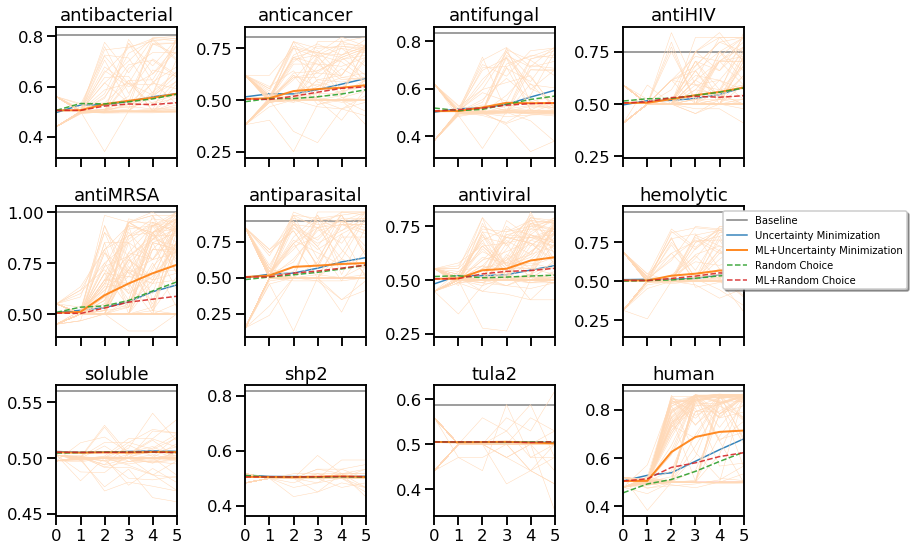

In [25]:
plot_strategy('reptile-models', 'models', 'umin', zoom=True)

Data Standard umin Random ML+umin Random ML+Random
antibacterial & $0.81$ & $0.76 \pm 0.13$ & $0.74 \pm 0.14$
anticancer & $0.80$ & $0.73 \pm 0.16$ & $0.75 \pm 0.14$
antifungal & $0.83$ & $0.74 \pm 0.16$ & $0.77 \pm 0.14$
antiHIV & $0.89$ & $0.76 \pm 0.13$ & $0.75 \pm 0.17$
antiMRSA & $1.00$ & $0.94 \pm 0.15$ & $0.89 \pm 0.13$
antiparasital & $0.87$ & $0.88 \pm 0.19$ & $0.88 \pm 0.13$
antiviral & $0.91$ & $0.70 \pm 0.16$ & $0.71 \pm 0.22$
hemolytic & $0.99$ & $0.72 \pm 0.17$ & $0.74 \pm 0.17$
soluble & $0.62$ & $0.50 \pm 0.02$ & $0.51 \pm 0.02$
shp2 & $0.83$ & $0.51 \pm 0.10$ & $0.51 \pm 0.11$
tula2 & $0.64$ & $0.46 \pm 0.10$ & $0.50 \pm 0.07$
human & $0.89$ & $0.81 \pm 0.14$ & $0.82 \pm 0.11$


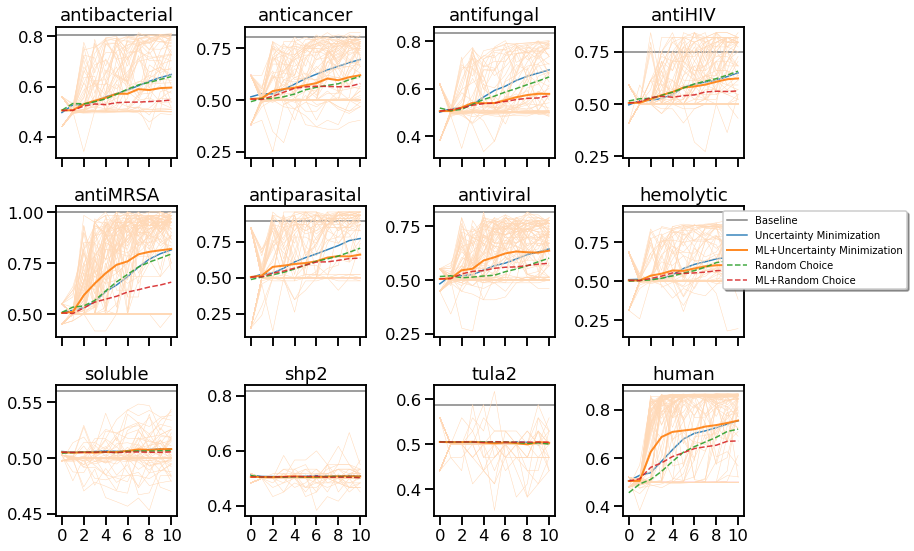

In [26]:
plot_strategy('reptile-models', 'models', 'umin')

Data Standard umin Randomantibacterial & $0.81$ & $0.74 \pm 0.14$ & $0.76 \pm 0.13$
anticancer & $0.80$ & $0.75 \pm 0.14$ & $0.73 \pm 0.16$
antifungal & $0.83$ & $0.77 \pm 0.14$ & $0.74 \pm 0.16$
antiHIV & $0.89$ & $0.75 \pm 0.17$ & $0.76 \pm 0.13$
antiMRSA & $1.00$ & $0.89 \pm 0.13$ & $0.94 \pm 0.15$
antiparasital & $0.87$ & $0.88 \pm 0.13$ & $0.88 \pm 0.19$
antiviral & $0.91$ & $0.71 \pm 0.22$ & $0.70 \pm 0.16$
hemolytic & $0.99$ & $0.74 \pm 0.17$ & $0.72 \pm 0.17$
soluble & $0.62$ & $0.51 \pm 0.02$ & $0.50 \pm 0.02$
shp2 & $0.83$ & $0.51 \pm 0.11$ & $0.51 \pm 0.10$
tula2 & $0.64$ & $0.50 \pm 0.07$ & $0.46 \pm 0.10$
human & $0.89$ & $0.82 \pm 0.11$ & $0.81 \pm 0.14$


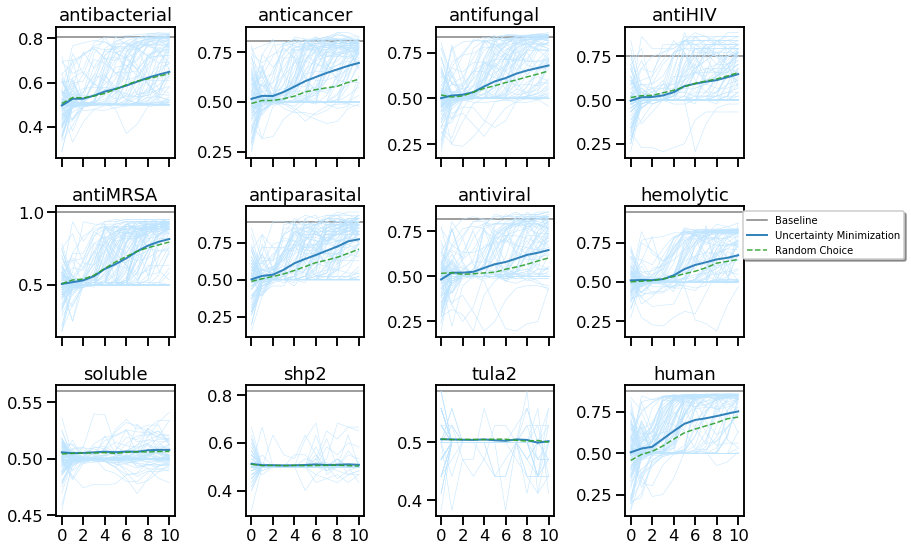

In [27]:
plot_strategy('reptile-models', 'models', 'umin', ml=False)

Data Standard qbc Randomantibacterial & $0.81$ & $0.74 \pm 0.13$ & $0.76 \pm 0.13$
anticancer & $0.80$ & $0.75 \pm 0.14$ & $0.73 \pm 0.16$
antifungal & $0.83$ & $0.74 \pm 0.16$ & $0.74 \pm 0.16$
antiHIV & $0.89$ & $0.79 \pm 0.13$ & $0.76 \pm 0.13$
antiMRSA & $1.00$ & $0.90 \pm 0.14$ & $0.94 \pm 0.15$
antiparasital & $0.87$ & $0.87 \pm 0.15$ & $0.88 \pm 0.19$
antiviral & $0.91$ & $0.74 \pm 0.19$ & $0.70 \pm 0.16$
hemolytic & $0.99$ & $0.75 \pm 0.17$ & $0.72 \pm 0.17$
soluble & $0.62$ & $0.51 \pm 0.02$ & $0.50 \pm 0.02$
shp2 & $0.83$ & $0.51 \pm 0.10$ & $0.51 \pm 0.10$
tula2 & $0.64$ & $0.49 \pm 0.08$ & $0.46 \pm 0.10$
human & $0.89$ & $0.84 \pm 0.08$ & $0.81 \pm 0.14$


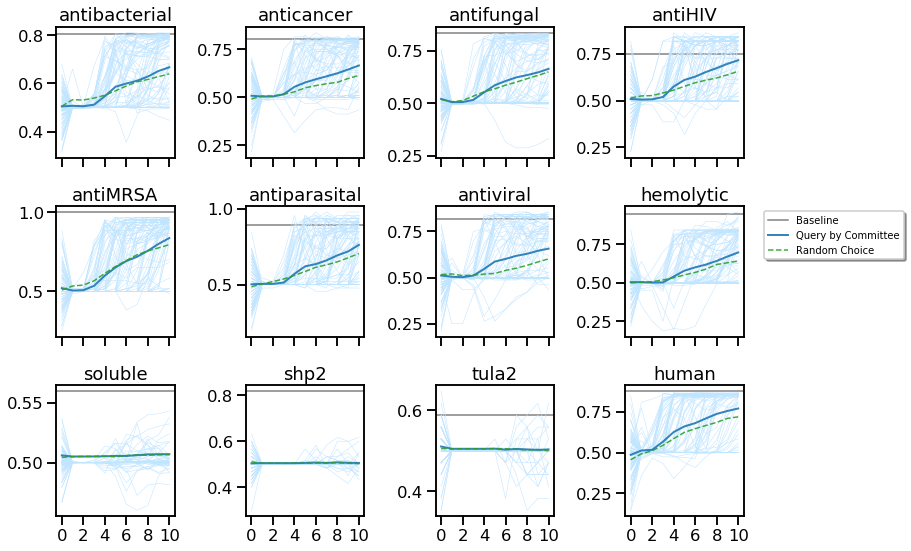

In [28]:
plot_strategy('reptile-weights', 'models', 'qbc', ml=False)

Data Standard qbc Random ML+qbc Random ML+Random
antibacterial & $0.81$ & $0.76 \pm 0.13$ & $0.74 \pm 0.13$
anticancer & $0.80$ & $0.73 \pm 0.16$ & $0.75 \pm 0.14$
antifungal & $0.83$ & $0.74 \pm 0.16$ & $0.74 \pm 0.16$
antiHIV & $0.89$ & $0.76 \pm 0.13$ & $0.79 \pm 0.13$
antiMRSA & $1.00$ & $0.94 \pm 0.15$ & $0.90 \pm 0.14$
antiparasital & $0.87$ & $0.88 \pm 0.19$ & $0.87 \pm 0.15$
antiviral & $0.91$ & $0.70 \pm 0.16$ & $0.74 \pm 0.19$
hemolytic & $0.99$ & $0.72 \pm 0.17$ & $0.75 \pm 0.17$
soluble & $0.62$ & $0.50 \pm 0.02$ & $0.51 \pm 0.02$
shp2 & $0.83$ & $0.51 \pm 0.10$ & $0.51 \pm 0.10$
tula2 & $0.64$ & $0.46 \pm 0.10$ & $0.49 \pm 0.08$
human & $0.89$ & $0.81 \pm 0.14$ & $0.84 \pm 0.08$


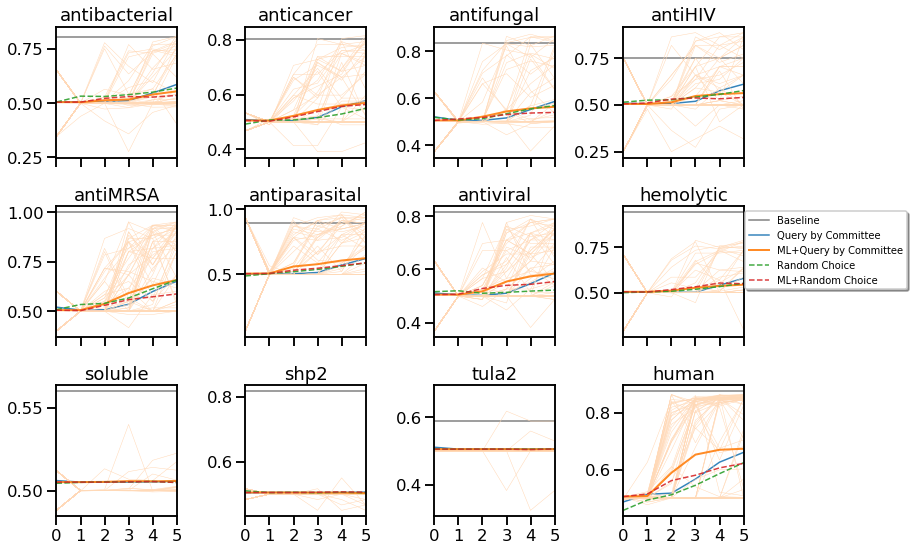

In [29]:
plot_strategy('reptile-models', 'models', 'qbc', ml=True, zoom=True)

Data Standard qbc Random ML+qbc Random ML+Random
antibacterial & $0.81$ & $0.76 \pm 0.13$ & $0.74 \pm 0.13$
anticancer & $0.80$ & $0.73 \pm 0.16$ & $0.75 \pm 0.14$
antifungal & $0.83$ & $0.74 \pm 0.16$ & $0.74 \pm 0.16$
antiHIV & $0.89$ & $0.76 \pm 0.13$ & $0.79 \pm 0.13$
antiMRSA & $1.00$ & $0.94 \pm 0.15$ & $0.90 \pm 0.14$
antiparasital & $0.87$ & $0.88 \pm 0.19$ & $0.87 \pm 0.15$
antiviral & $0.91$ & $0.70 \pm 0.16$ & $0.74 \pm 0.19$
hemolytic & $0.99$ & $0.72 \pm 0.17$ & $0.75 \pm 0.17$
soluble & $0.62$ & $0.50 \pm 0.02$ & $0.51 \pm 0.02$
shp2 & $0.83$ & $0.51 \pm 0.10$ & $0.51 \pm 0.10$
tula2 & $0.64$ & $0.46 \pm 0.10$ & $0.49 \pm 0.08$
human & $0.89$ & $0.81 \pm 0.14$ & $0.84 \pm 0.08$


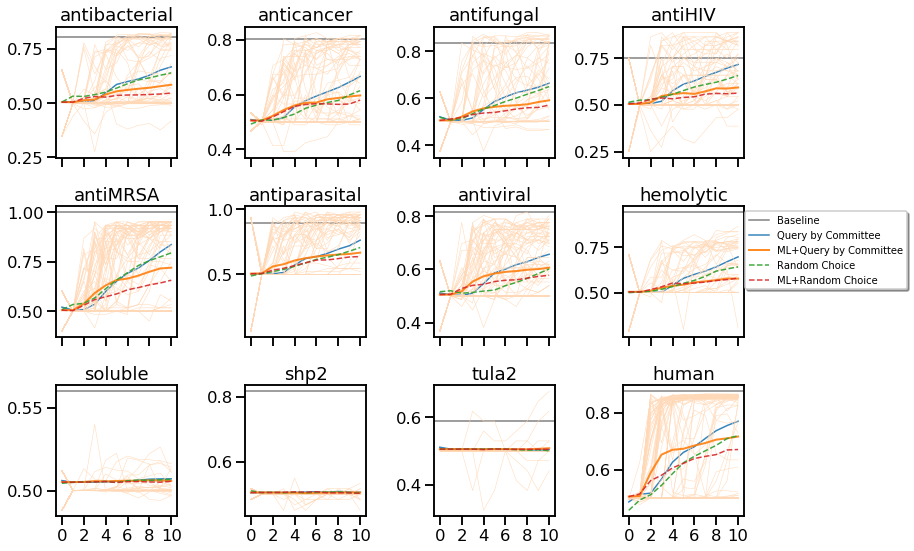

In [23]:
plot_strategy('reptile-models', 'models', 'qbc', ml=True)